In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import transforms
import pytorch_lightning as pl

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('max_colwidth', -1)

from datasets import PlatCLEFSimCLR, PlantCLEF2022_Dataset


C:\Users\maeot\AppData\Local\Temp/ipykernel_14200/3253629878.py:15: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


In [2]:
columns = ["classid", "classid", "image_path", "species", "genus", "family"]
df_web = pd.read_csv("web/PlantCLEF2022_web_training_metadata.csv", sep=";", usecols=columns)
# df_trusted = pd.read_csv("trusted/PlantCLEF2022_trusted_training_metadata.csv", sep=";", usecols=columns)

In [3]:
df_web.head()

,classid,image_path,species,genus,family
0,2683260,2683260/f402e9eb580a5a46470e60aae20c9239971f95ac.jpg,Cycas angulata R.Br.,Cycas,Cycadaceae
1,2683260,2683260/2ffcb2e0dd5a93697a7e37c4dee3fdcdff2a7914.jpg,Cycas angulata R.Br.,Cycas,Cycadaceae
2,2683260,2683260/987a5e1aaf1447a759ff75c3bbdf9bd7edac896f.jpg,Cycas angulata R.Br.,Cycas,Cycadaceae
3,2683260,2683260/4be17a768060b5b3f0ca4d340971ca7be3c90eb4.jpg,Cycas angulata R.Br.,Cycas,Cycadaceae
4,2683260,2683260/409ba823af52a3422de929d9344d1c8cd36cf4c3.jpg,Cycas angulata R.Br.,Cycas,Cycadaceae


In [4]:
df_web.shape#, df_trusted.shape

(1071627, 5)

In [5]:
# df_trusted.classid.nunique(),  df_trusted.species.nunique(), df_trusted.genus.nunique(), df_trusted.family.nunique()


# Self-Supervised
    

## Data preparation

In [6]:
args = {}
args['description'] = 'PyTorch SimCLR'
args['epochs'] = 10
args['batch_size'] = 32
args['lr'] = 0.0003
args['weight_decay'] = 1e-4
args['out_dim'] = 128 
args['log_every_n_steps'] = 10
args['temperature'] = 0.07
args['n_views'] = 2
args['arch'] = 'resnet50'
args['seed'] = None
args['fp16_precision'] = True
args['num_workers'] = 4
args['checkpoints'] = "selfsupr_checkpoints"

In [7]:

ds_sim = PlatCLEFSimCLR(df_web, root="C:\\Users\\maeot\\Documents\\code\\biomachina\\web\\images\\", 
                           label_col="species", filename_col="image_path", size=224)
ds_sim

Dataset PlatCLEFSimCLR
    Number of datapoints: 68898
    Root Location: C:\Users\maeot\Documents\code\biomachina\web\images\
    Transforms (if any): <datasets.ContrastiveLearningViewGenerator object at 0x00000136955E35E0>

### Visualize sample

In [8]:
selfsupr_loader = torch.utils.data.DataLoader(ds_sim, batch_size=args['batch_size'], shuffle=True, drop_last=True, num_workers=args['num_workers'], persistent_workers=True)
selfsupr_iter = iter(selfsupr_loader)
images, labels = selfsupr_iter.next() #images = list with 2 tensors of (B, C, H, W)


In [9]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


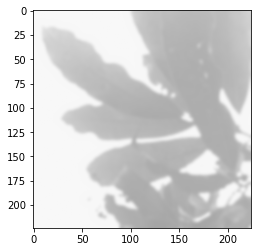

In [10]:
imshow(images[0][0])

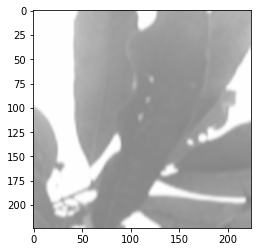

In [11]:
imshow(images[1][0])

## Training

In [12]:
from models import ResNetSelfSupr
from engines import SimCLREngine

model = ResNetSelfSupr(base_model=args['arch'], out_dim=args['out_dim'])
engine = SimCLREngine(model=model, loader=selfsupr_loader, args=args)


In [13]:
from pytorch_lightning.callbacks import ModelCheckpoint

SAVE_X_TIMES_PER_EPOCH = 0.1

checkpoint_callback = ModelCheckpoint(
    monitor="selfsupr_train_loss",
    dirpath=args["checkpoints"],
    save_top_k=2,
    mode="min",
    filename='selfsupr-{epoch}-{selfsupr_train_loss:.2f}-{selfsupr_train_acc_top1:.2f}',
    save_on_train_epoch_end = True,
    every_n_train_steps = int((len(ds_sim) / args['batch_size']) * SAVE_X_TIMES_PER_EPOCH)
)

trainer = pl.Trainer(gpus=1, num_nodes=1, precision=16, limit_train_batches=0.5, callbacks=[checkpoint_callback])
trainer.fit(engine, selfsupr_loader)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ResNetSelfSupr   | 28.0 M
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
28.0 M    Trainable params
0         Non-trainable params
28.0 M    Total params
55.933    Total estimated model params size (MB)
C:\Users\maeot\anaconda3\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:631: UserWarning: Checkpoint directory C:\Users\maeot\Documents\code\biomachina\selfsupr_checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Training: 0it [00:00, ?it/s]

C:\Users\maeot\anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
